In [1]:
import sys
import os
import json
from shapely.geometry import shape
import numpy as np
from dask.distributed import Client, LocalCluster
from pystac_client import Client as StacClient
import stackstac
import pandas as pd
import warnings
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
cluster = LocalCluster(
    n_workers=4,             
    threads_per_worker=1,    
    memory_limit="6GB"       
)

client = Client(cluster)
cluster

LocalCluster(0997e140, 'tcp://127.0.0.1:42913', workers=4, threads=4, memory=22.35 GiB)

In [3]:
# Add the folder containing WQI_utils.py
sys.path.append(os.path.abspath("../utils"))

# Import the main functions
from WQI_utils import compute_wqi_indices
from plots_utils import (
    plot_wqi_time_series, 
    plot_wqi_seasonal, 
    plot_wqi_seasons, 
    plot_wqi_pie_charts  
)

In [4]:
TAMPA_BAY = (-82.7167, 27.5833, -82.3833, 28.0333)

start_date = "2019-12-01"
end_date = "2024-12-31"

In [5]:
df_full, df_roll_full, monthly_full = compute_wqi_indices(
    bbox=TAMPA_BAY,
    start_date=start_date,
    end_date=end_date,
    max_items=500,           
    filter_clouds=True
)
print("Full Tampa_Bay results shape:", df_full.shape)
print("Stack ready for maps!")

Cloud filtered: 500 → 172 scenes (<20.0% cloud cover)

=== FULL DATA QUALITY DIAGNOSTICS (First 5 Scenes) ===


/opt/conda/envs/geog313-final-project/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(



SCENE 1: 2024-12-23 | ID: S2B_17RL...
Thumbnail: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/17/R/LL/2024/12/S2B_17RLL_20241223_0_L2A/thumbnail.jpg
Cloud cover (metadata): 0.066426%
SCL analysis failed: Reindexing only valid with uniquely valued Index objects
NDWI check failed: cannot access local variable 'scene' where it is not associated with a value
--------------------------------------------------------------------------------

SCENE 2: 2024-12-18 | ID: S2A_17RL...
Thumbnail: https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/17/R/LL/2024/12/S2A_17RLL_20241218_0_L2A/thumbnail.jpg
Cloud cover (metadata): 17.235643%
SCL analysis failed: Reindexing only valid with uniquely valued Index objects
NDWI check failed: cannot access local variable 'scene' where it is not associated with a value
--------------------------------------------------------------------------------

SCENE 3: 2024-12-13 | ID: S2B_17RL...
Thumbnail: https://sentinel-cogs

2025-12-17 21:05:56,365 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 4.55 GiB -- Worker memory limit: 5.59 GiB
2025-12-17 21:05:56,443 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.64 GiB -- Worker memory limit: 5.59 GiB
2025-12-17 21:05:56,576 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 4.46 GiB -- Worker memory limit: 5.59 GiB
2025-12-17 21:05:58,484 - distributed.worker.memory - WARNING - Worker is at 83% memory usage. Pausing worker.  Process memory: 4.64 GiB -- Worker memory limit: 5.59 GiB
2025-12-17 21:05:58,598 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memory: 4.46 GiB 

Shape: (172, 6)
Columns: ['ndwi_mean', 'ndwi_median', 'ndti_mean', 'ndti_median', 'ndci_mean', 'ndci_median']
Shape: (172, 6)
Analysis complete: 172 scenes processed
NDWI range: -0.275 to 0.644
Full Tampa_Bay results shape: (172, 7)
Stack ready for maps!


In [7]:
print("TAMPA_BAY FULL results shape:", df_full.shape)
print(df_full.head())
print("\nColumns:", df_full.columns.tolist())
print("\nRolling shape:", df_roll_full.shape)
print(monthly_full.round(3))

TAMPA_BAY FULL results shape: (172, 7)
                         ndwi_mean  ndwi_median  ndti_mean  ndti_median  \
date                                                                      
2021-09-25 16:15:36.049   0.257923     0.505703  -0.121553    -0.118750   
2021-09-25 16:15:50.597   0.425291     0.565217  -0.191604    -0.200000   
2021-09-30 16:15:31.850   0.224211     0.476562  -0.111965    -0.095679   
2021-09-30 16:15:31.851   0.258055     0.540984  -0.119507    -0.104558   
2021-09-30 16:15:46.406   0.469304     0.642857  -0.226110    -0.253219   

                         ndci_mean  ndci_median  month  
date                                                    
2021-09-25 16:15:36.049   0.073913     0.059848      9  
2021-09-25 16:15:50.597   0.064781     0.050000      9  
2021-09-30 16:15:31.850   0.054646     0.031920      9  
2021-09-30 16:15:31.851   0.046491     0.026549      9  
2021-09-30 16:15:46.406  -0.010848    -0.004049      9  

Columns: ['ndwi_mean', 'ndwi_median

In [9]:
# Get the repo root
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))  # adjust depending on notebook location

# Define the correct folder for processed data
results_path = os.path.join(project_root, "data/processed")
os.makedirs(results_path, exist_ok=True)

# Save all outputs there
df_full.to_csv(os.path.join(results_path, "indices_results.csv"))
df_roll_full.to_csv(os.path.join(results_path, "indices_rolling.csv"))
monthly_full.to_csv(os.path.join(results_path, "indices_monthly.csv"))

print("Saved processed outputs in:", os.path.abspath(results_path))


Saved processed outputs in: /home/jupyteruser/data/processed


## Plotting Time Series (Mean and Median)

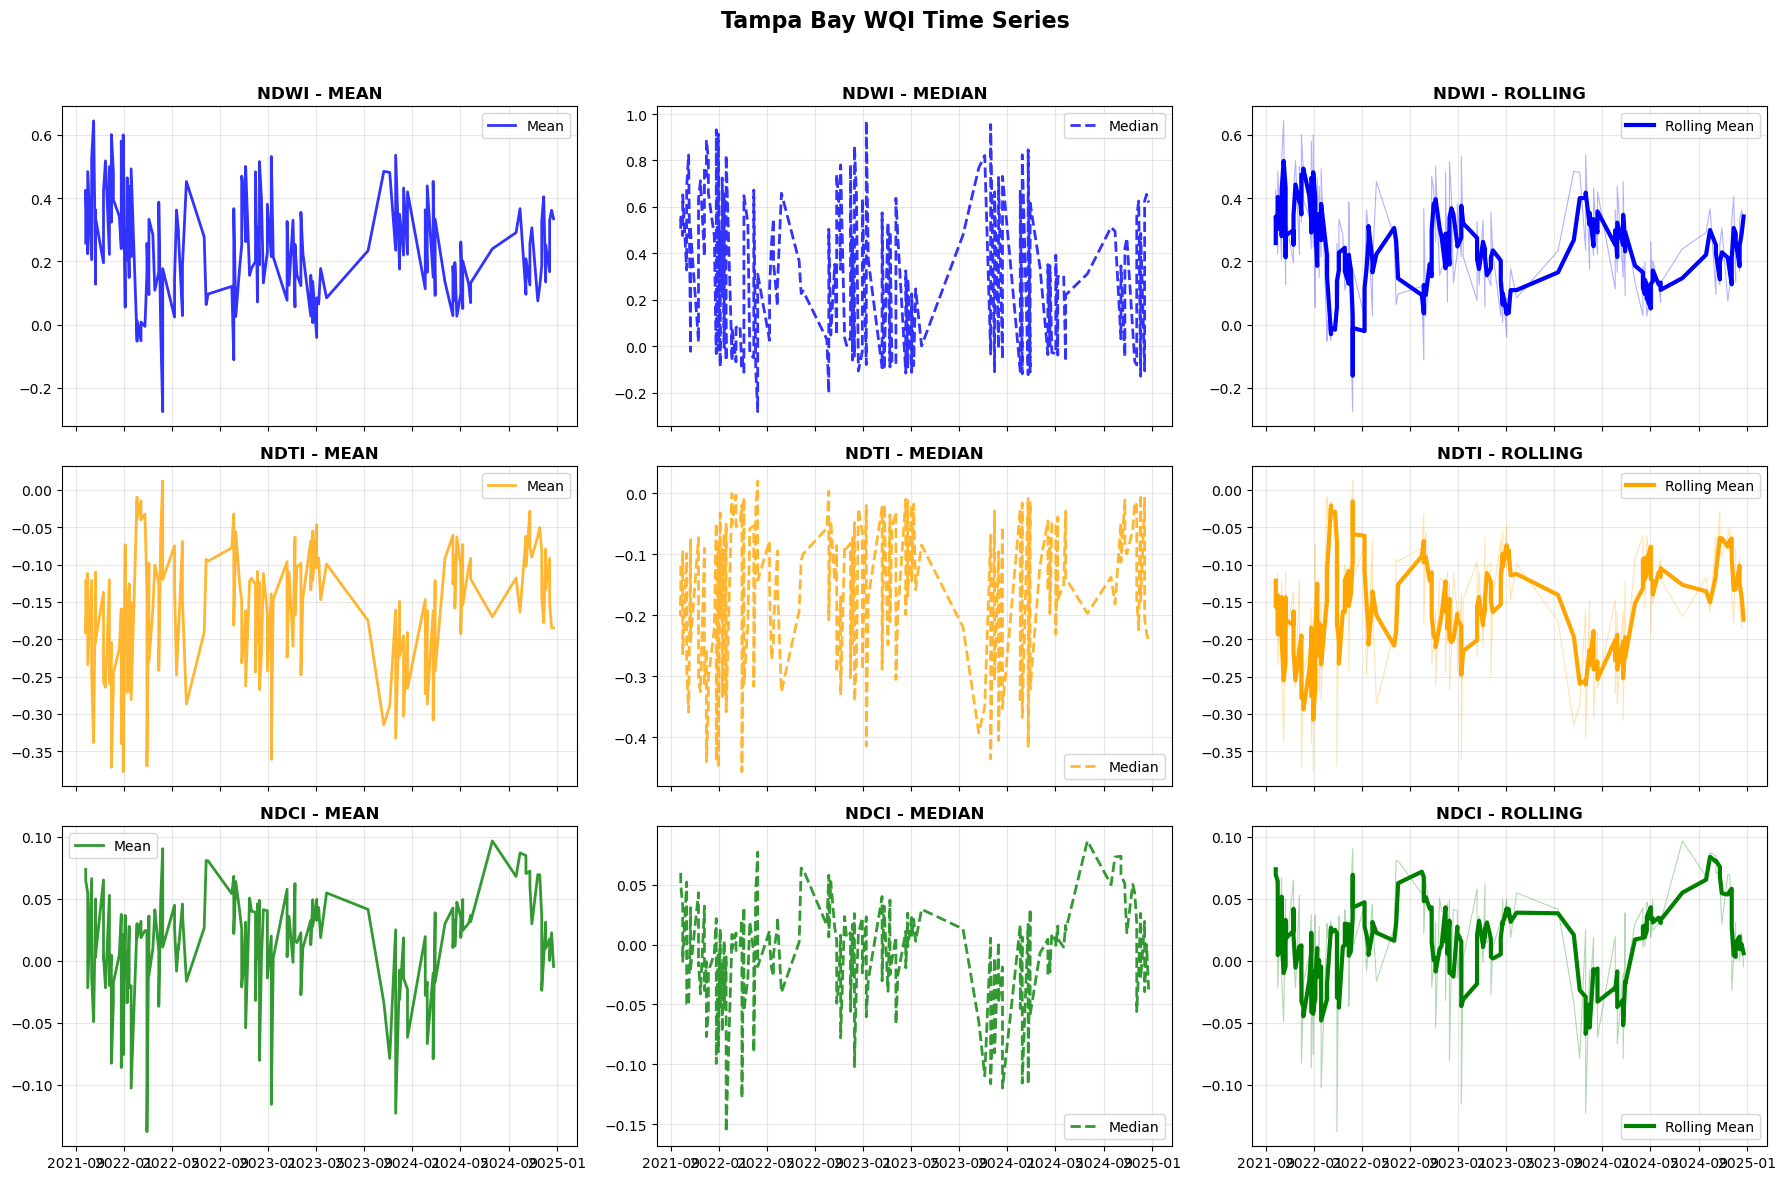

In [10]:
plot_wqi_time_series(df_full, df_roll_full, title="Tampa Bay WQI Time Series")

## Plotting Seasonal Cycle (Mean and Median)

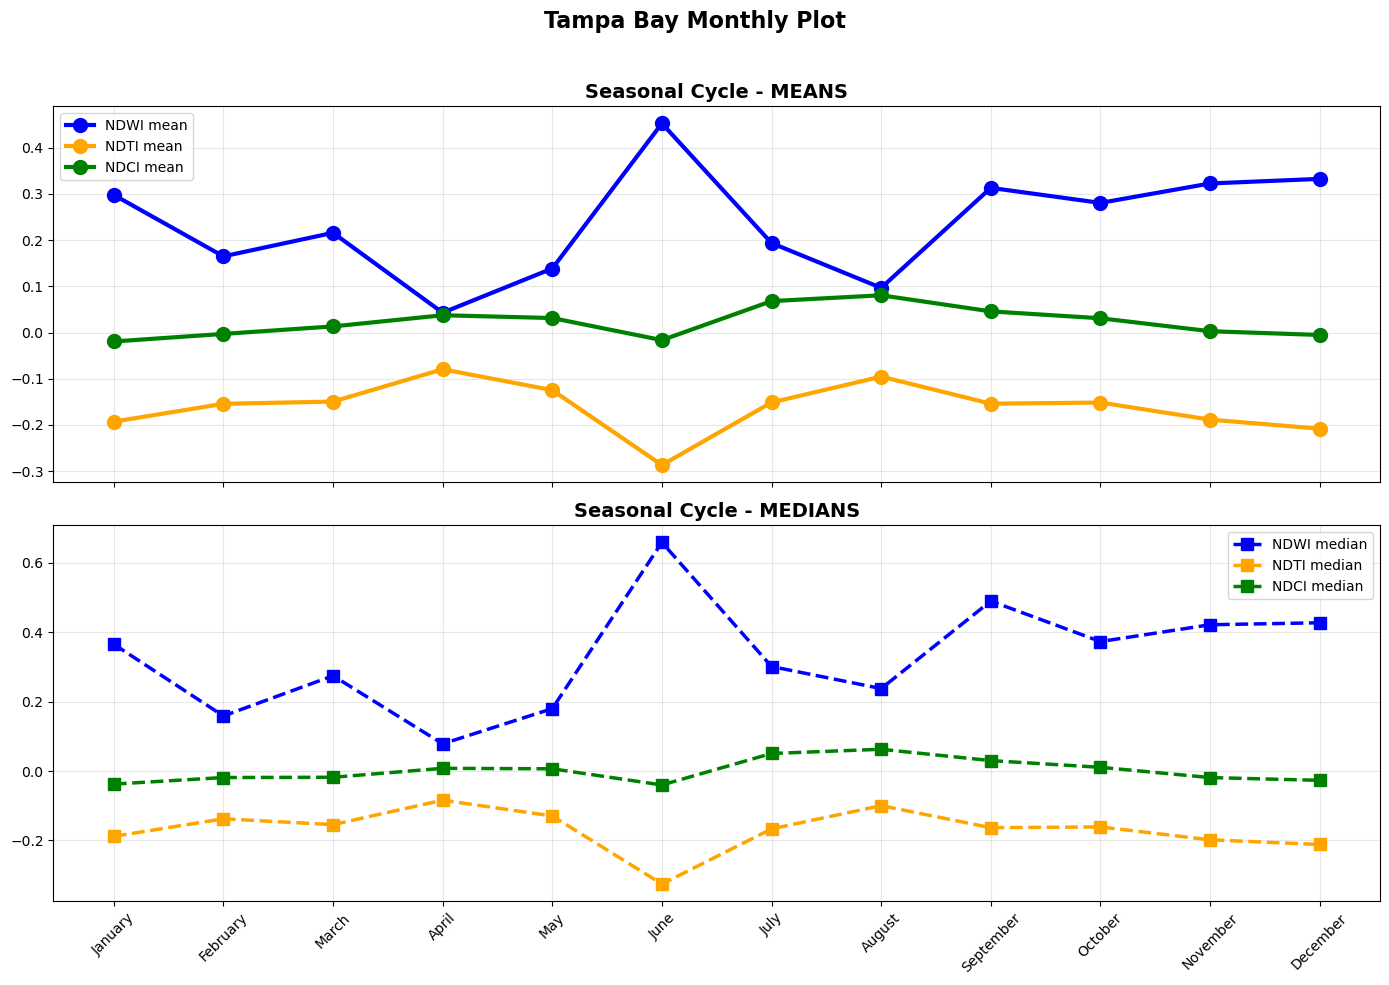

In [11]:
plot_wqi_seasonal(monthly_full, title="Tampa Bay Monthly Plot")

## Plotting Seasons (Mean)

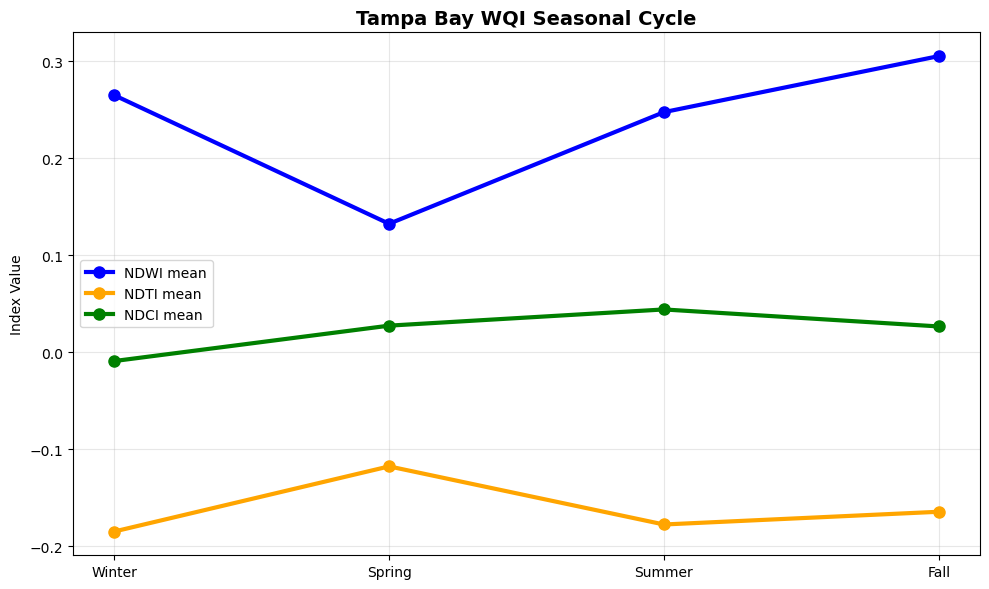

In [12]:
# Indexing to Datetime
monthly_full.index = pd.to_datetime(monthly_full.index, format='%B')

plot_wqi_seasons(monthly_full, title="Tampa Bay WQI Seasonal Cycle")

## Generating Pie Chat to Identify Water Quality State

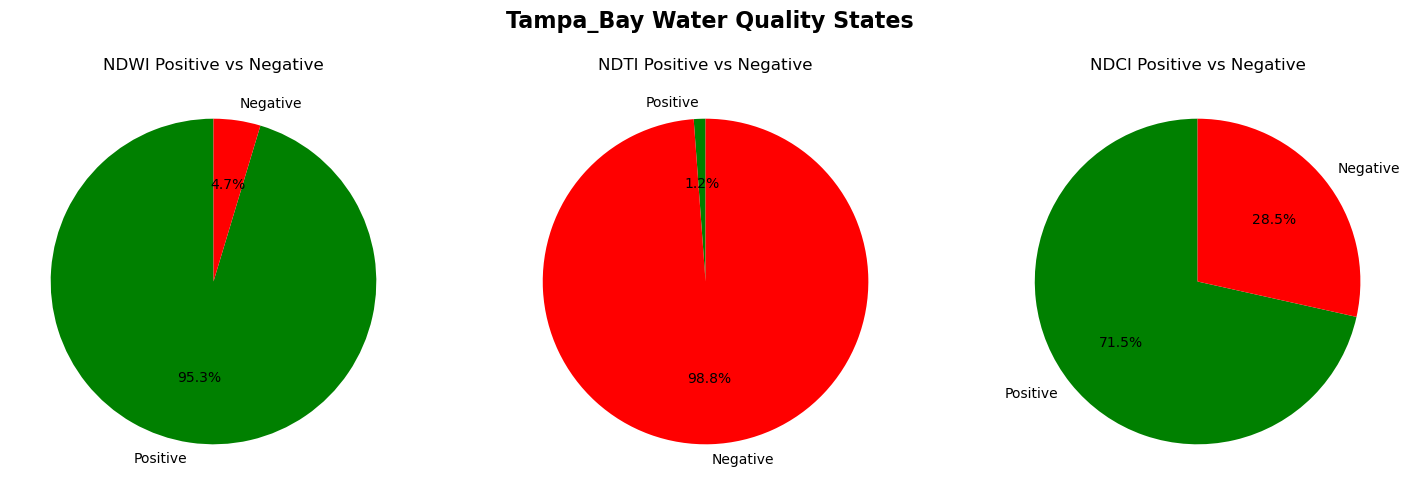

In [13]:
plot_wqi_pie_charts(df_full, title="Tampa_Bay Water Quality States")